## **Business Understanding**

**Business Overview**

Consumer technology companies such as Apple and Google receive a high volume of public feedback about their products on social media platforms, particularly Twitter. Customers frequently use Twitter to share opinions, report issues, and react to product updates in real time. While this feedback is valuable for understanding public perception, the sheer volume and speed of incoming data make manual monitoring impractical.

Brand and product insights teams rely on timely information to identify emerging customer concerns, assess overall sentiment trends, and protect brand reputation. Without automated tools, negative sentiment can go unnoticed until it escalates into larger public relations or customer satisfaction issues.

**Problem Statement**

The company currently lacks an efficient, scalable method to automatically identify whether tweets directed at its brands or products express positive or negative sentiment. As a result, potentially critical negative feedback may be missed or identified too late, limiting the company’s ability to respond proactively to customer concerns.

The informal and noisy nature of Twitter data—including slang, abbreviations, sarcasm, and short text length—further complicates manual analysis and traditional rule-based approaches, making automated sentiment classification a challenging but necessary solution.

**Business Objective**

The objective of this project is to develop a proof-of-concept Natural Language Processing (NLP) model that can automatically classify the sentiment of tweets directed at brands and products. The initial focus is on distinguishing negative sentiment from positive sentiment, as early detection of negative feedback is most valuable for brand monitoring and issue escalation.

Model performance will be evaluated using metrics aligned with this objective, with particular emphasis on correctly identifying negative sentiment. In addition to predictive performance, the project aims to provide interpretable model outputs that help stakeholders understand why a tweet is classified as negative or positive, supporting trust and practical adoption of the system.

In [19]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# Read the dataset
data = pd.read_csv(
    "../data/judge-1377884607_tweet_product_company.csv",
    encoding="latin1")

data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## **Data Understanding**

**Dataset Overview**

This project uses the Judge Emotion About Brands and Products dataset, a crowdsourced collection of Twitter posts labeled for sentiment toward brands and products. The dataset contains 9,093 tweet entries, each represented by three text-based columns. The data was labeled by human annotators to indicate whether a tweet expresses emotion toward a brand or product and, if so, the target of that emotion.

The dataset is relatively small in size (approximately 1.2 MB), making it suitable for rapid experimentation and model iteration, while still capturing the challenges of real-world social media text.

**Data Structure and Features**

The dataset consists of the following columns:

1. *tweet_text*

- Contains the raw text of each tweet. This is the primary feature used for modeling. One entry is missing, indicating minimal but non-zero missing data in the text field.

2. *emotion_in_tweet_is_directed_at*

- Indicates the specific brand or product that the expressed emotion is directed toward. This column contains a large number of missing values (approximately 64%), reflecting that many tweets either do not clearly target a specific brand/product or that annotators could not confidently identify the target.

3. *is_there_an_emotion_directed_at_a_brand_or_product*

- Indicates whether the tweet expresses an emotion toward a brand or product and implicitly captures sentiment polarity. This column is fully populated and serves as the primary source for deriving sentiment labels.

All columns are stored as text (object dtype), which is expected given the nature of the data.

**Data Quality and Challenges**

Several data quality challenges are present:

*Missing values:*
- While tweet_text is nearly complete, the emotion_in_tweet_is_directed_at column contains substantial missing data. This limits its usefulness for modeling and motivates excluding entity-level analysis from the project scope.

*Noisy text:*
- Tweets are short, informal, and often include slang, abbreviations, hashtags, user mentions, URLs, and emojis. These characteristics increase sparsity and variability in the text data.

*Ambiguous sentiment:*
- Some tweets express weak, mixed, or unclear sentiment, making sentiment classification inherently subjective despite human annotation.

*Class imbalance:*
- Tweets with no expressed emotion are expected to be more common than clearly positive or negative tweets, which has implications for model evaluation and metric selection.

## **Data Cleaning**

**Cleaning Objectives**

The objective of the data cleaning process is to prepare raw Twitter text for sentiment classification while minimizing noise and ambiguity. Specifically, the cleaning steps aim to (1) remove unusable observations, (2) define a clear and consistent target variable for supervised learning, and (3) normalize tweet text in a way that preserves sentiment-relevant information such as negation.

**Handling Missing Data**

The dataset contains a small number of missing values in the tweet_text column. Since tweet text is the primary input feature for this NLP task, rows with missing tweet content cannot contribute to model training and are removed.

In [22]:
# Drop rows with missing tweet text

data = data.dropna(subset=['tweet_text'])

**Target Variable Definition**

The column is_there_an_emotion_directed_at_a_brand_or_product contains sentiment annotations indicating whether a tweet expresses positive, negative, or no emotion toward a brand or product. Before defining the target variable, the distribution of these labels is inspected to understand class balance and annotation structure.

In [23]:
# Inspect the distribution of sentiment labels
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

**Key Observations**

- The dataset is highly imbalanced, with the majority of samples expressing no emotion.

- Negative sentiment, while rare, is business-critical due to its association with brand risk and customer dissatisfaction.

- The “I can’t tell” category is ambiguous and not actionable.

In [37]:
# Remove ambigious samples

data = data[data['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

**Justification**

- These samples introduce noise and uncertainty.

- The category has no direct business value for decision-making.

**Label standardization**

In [25]:
# Map original labels to standardized sentiment categories
label_mapping ={
    "No emotion toward brand or product": 0,
    "Positive emotion": 1,
    "Negative emotion": 2
}

data['sentiment'] = data['is_there_an_emotion_directed_at_a_brand_or_product'].map(label_mapping)

In [26]:
data['sentiment'].value_counts()

0    5388
1    2978
2     570
Name: sentiment, dtype: int64

In [27]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8936 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8936 non-null   object
 3   sentiment                                           8936 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 349.1+ KB


**Feature Selection**

After defining the target variable, only the relevant columns are retained. The emotion_in_tweet_is_directed_at column is excluded due to its high proportion of missing values and because entity-level attribution is outside the scope of this project.

In [29]:
# Retain only the columns required for modelling
df = data[['tweet_text', 'sentiment']]
df.head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1


**Text Normalization and Cleaning**

Twitter text is highly unstructured and contains elements such as URLs, user mentions, hashtags, and inconsistent casing. These elements are normalized using the following steps:

- Convert text to lowercase

- Remove URLs and user mentions

- Remove hashtag symbols while retaining the associated words

- Remove non-alphabetic characters

- Remove stopwords while preserving negation terms

- Lemmatize words to reduce sparsity while preserving semantic meaning

The Natural Language Toolkit (NLTK) is used for linguistic preprocessing.

In [30]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
# Negation terms are retained due to their importance in sentiment analysis
stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Cleans and normalizes tweet text for NLP modeling.
    """
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    
    # Remove user mentions
    text = re.sub(r"@\w+", "", text)
    
    # Remove hashtag symbols but keep the words
    text = re.sub(r"#", "", text)
    
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize text
    tokens = text.split()
    
    # Remove stopwords and apply lemmatization
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]
    
    # Rejoin tokens into a cleaned string
    return " ".join(tokens)

# Apply text cleaning to all tweets
df['clean_tweet'] = df['tweet_text'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\O M E
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\O M E
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-30-b9019fce6a79>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_tweet'] = df['tweet_text'].apply(clean_text)


In [31]:
df.head(10)

,tweet_text,sentiment,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,2,g iphone hr tweeting riseaustin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,1,not wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,2,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,great stuff fri sxsw marissa mayer google tim ...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,0,new ipad apps speechtherapy communication show...
7,"#SXSW is just starting, #CTIA is around the co...",1,sxsw starting ctia around corner googleio hop ...
8,Beautifully smart and simple idea RT @madebyma...,1,beautifully smart simple idea rt wrote hollerg...
9,Counting down the days to #sxsw plus strong Ca...,1,counting day sxsw plus strong canadian dollar ...
10,Excited to meet the @samsungmobileus at #sxsw ...,1,excited meet sxsw show sprint galaxy still run...


**Resulting Dataset**

After cleaning and preprocessing, the dataset consists of normalized tweet text and a binary sentiment label suitable for supervised NLP modeling. These steps reduce noise, improve consistency, and ensure that the cleaned text retains the linguistic information most relevant for sentiment classification.

## **Exploratory Data Analysis (EDA)**

**Purpose of EDA**

The goal of this EDA is not visualization for its own sake, but to understand the structure of the text data and class distribution in order to justify preprocessing choices, modeling approach, and evaluation strategy.
All analyses below directly inform decisions made in later modeling stages.

**1. Sentiment Class Distribution**

  Understanding the distribution of sentiment labels is critical for:

- Choosing between binary vs multiclass classification

- Selecting appropriate evaluation metrics

- Designing a valid train/test split strategy



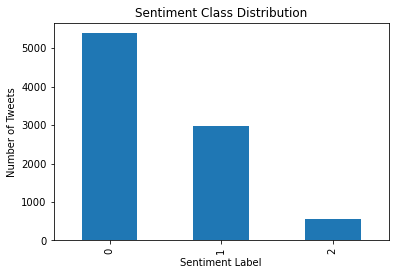

0    5388
1    2978
2     570
Name: sentiment, dtype: int64

In [32]:
# Count sentiment classes
sentiment_counts = df['sentiment'].value_counts().sort_index()

# Plot class distribution
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Tweets')
plt.show()

sentiment_counts

**Interpretation**

- The dataset is highly imbalanced, with neutral sentiment dominating.

- Negative sentiment represents a relatively small but business-critical portion of the data.

- Positive sentiment further increases imbalance in a multiclass setting.

**Decision Justification**

- Accuracy alone would be misleading.

- Recall and F1-score will be prioritized.

- A binary classification approach (Positive vs Negative) is appropriate for a proof-of-concept model.

**2. Tweet Length Analysis**

 Analyzing tweet length helps determine:

- Whether truncation is necessary

- Whether advanced deep learning models are justified

- The appropriateness of bag-of-words representations

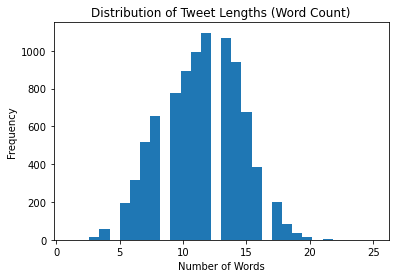

count    8936.000000
mean       11.355304
std         3.092799
min         1.000000
25%         9.000000
50%        12.000000
75%        14.000000
max        25.000000
Name: tweet_length, dtype: float64

In [33]:
# Compute tweet lengths
df['tweet_length'] = df['clean_tweet'].apply(lambda x: len(x.split()))

# Plot distribution of tweet lengths
plt.figure(figsize=(6, 4))
plt.hist(df['tweet_length'], bins=30)
plt.title('Distribution of Tweet Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

df['tweet_length'].describe()


**Interpretation**

- Most tweets are short, typically under 20–25 words.

- Very few extreme outliers exist.

- The brevity of tweets limits the benefit of long-context models.

**Decision Justification**

- TF-IDF vectorization is well-suited for short text.

- Deep learning models are unnecessary for this dataset.

- N-grams beyond bigrams are unlikely to provide significant value.

**3. Vocabulary Size and Sparsity**

 Understanding vocabulary size helps guide:

- Feature dimensionality constraints

- Regularization needs

- Model interpretability

In [34]:
# Tokenize cleaned tweets
all_words = ' '.join(df['clean_tweet']).split()

# Unique vocabulary size
vocab_size = len(set(all_words))

vocab_size


9343

**Interpretation**

- The vocabulary is relatively large compared to dataset size.

- This implies high sparsity in the document-term matrix.

**Decision Justification**

- Feature limits ( max_features) will be applied during vectorization.

- Regularized linear models (Logistic Regression) are appropriate.

- Stopword removal and lemmatization were necessary preprocessing steps.

**4. Most Frequent Terms After Cleaning**

Inspecting common words ensures:

- Cleaning did not remove meaningful content

- Brand-related terms remain intact

- Noise has been reduced effectively

In [35]:
from collections import Counter

# Get most common words
word_freq = Counter(all_words)
word_freq.most_common(20)


[('sxsw', 9377),
 ('link', 4247),
 ('rt', 2925),
 ('ipad', 2828),
 ('google', 2474),
 ('apple', 2217),
 ('iphone', 1486),
 ('store', 1482),
 ('new', 1080),
 ('austin', 946),
 ('app', 803),
 ('amp', 722),
 ('launch', 682),
 ('social', 629),
 ('circle', 624),
 ('popup', 590),
 ('today', 565),
 ('android', 562),
 ('not', 512),
 ('network', 464)]

**Interpretation**

- Common terms reflect brand names, products, and event references.

- Noise such as URLs, punctuation, and stopwords has been effectively removed.

**Decision Justification**

- Cleaning steps preserved semantic meaning.

- The text is suitable for vectorization and modeling.

**5. Brand Mentions (Business Context)**

Because this project focuses on brand sentiment, it is important to understand which brands dominate the dataset.

In [36]:
# Count brand mentions
data['brand'] = data['emotion_in_tweet_is_directed_at'].str.lower()

brand_counts = data['brand'].value_counts().head(10)
brand_counts


ipad                               942
apple                              659
ipad or iphone app                 470
google                             429
iphone                             296
other google product or service    292
android app                         81
android                             78
other apple product or service      35
Name: brand, dtype: int64

**Interpretation**

- Apple-related products dominate the dataset.

- Android products appear less frequently.

**Decision Justification**

- Model predictions may be biased toward Apple-related sentiment.

- This limitation will be explicitly stated in the final recommendations.